In [1]:
import torch

import pickle
import time

import copy

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
MODEL_FOLDER = "./m_tstrans_models/"
synthetic = False

In [3]:
!rm -rf $MODEL_FOLDER
!mkdir  $MODEL_FOLDER

In [4]:
def series_to_supervised(data, col_name='PM2.5', input_length=7, output_length=1, dropnan=True):
    features = 1 if type(data) is list else data.shape[1]
    df_new = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(input_length, 0, -1):
        cols.append(df_new.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for j in range(features)]
        
    for i in range(0, output_length):
        cols.append(df_new.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_name)) for j in range(features)]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for j in range(features)]
    df_final = pd.concat(cols, axis=1)
    df_final.columns = names
    if dropnan:
        df_final.dropna(inplace=True)
    return df_final

def series_to_supervised_multiple_features(station_df, target_column, input_length):
    sub_supervised_df_list = []

    for column in station_df.columns:
        sub_df = series_to_supervised(station_df[[column]], column, input_length)
        sub_supervised_df_list.append(sub_df)

    desired_shape = (sub_supervised_df_list[0].shape[0], input_length, len(sub_supervised_df_list))
    supervised_data = []
    for input_idx in range(input_length):
        sub_df = pd.DataFrame()
        for column_idx in range(len(sub_supervised_df_list)):
            sub_df = pd.concat([sub_df, sub_supervised_df_list[column_idx].iloc[:, input_idx]], axis=1)
        supervised_data.append(sub_df.values.round(2))
    supervised_data = np.array(supervised_data).reshape(desired_shape)

    X, y = supervised_data, station_df[target_column].values[input_length:].reshape(-1, 1)
    
    return X, y

In [5]:
def get_batch(feature_source, target_source, i, batch_size):
    
    seq_len = min(batch_size, len(feature_source) - 1 - i)
    feature_data = feature_source[i:i+seq_len]     
    target_data = target_source[i:i+seq_len].reshape(-1, 1, 1)    

    input_ = torch.stack(torch.stack([item[0] for item in feature_data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[0] for item in target_data]).chunk(input_window, 1))
    
    # Shape
    # ---
    # input_ - (input_window, batch_size, 1)
    # target - (input_window, batch_size, 1)
    # I know this looks counterintuitive, but bear with me. 
    # URL : https://stackoverflow.com/questions/65451265/pytorch-why-batch-is-the-second-dimension-in-the-default-lstm
    
    return input_.reshape(input_.shape[2], input_.shape[1], input_.shape[0]), target


def train(model, optimizer, criterion, X_train_sc, y_train_sc):
    
    model.train() 
    
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(X_train_sc) - 1, batch_size)):
        data, targets = get_batch(X_train_sc, y_train_sc, i, batch_size)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, targets)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(X_train_sc) / batch_size / 5)
        
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
#             print('| Epoch {:03d} | {:05d}/{:05d} batches | '
#                   'lr {:02.6f} | {:5.2f} ms | '
#                   'loss {:5.5f}'.format(
#                    epoch, 
#                    batch, len(train_data) // batch_size, 
#                    scheduler.get_lr()[0],
#                    elapsed * 1000 / log_interval,
#                    cur_loss))
                  
            total_loss = 0
            start_time = time.time()
            
def evaluate(model, feature_source, target_source, criterion):
    model.eval()
    
    total_loss = 0.
    eval_batch_size = 1000
        
    with torch.no_grad():
        for i in range(0, len(feature_source) - 1, eval_batch_size):
            data, targets = get_batch(feature_source, target_source, i, eval_batch_size)
            output = model(data)            
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    
    return total_loss / len(feature_source)

def fit_ts_transformer(model, optimizer, scheduler, criterion, epochs,
                       X_train_sc, y_train_sc, X_test_sc, y_test_sc, verbose=False):
    
    best_model = None

    early_stop_flag = False
    min_model_loss = 1e9
    bad_model_loss_ctr = 0
    best_model_loss = float("inf")

    for epoch in range(1, epochs + 1):

        if (early_stop_flag):
            break

        epoch_start_time = time.time()
        train(model, optimizer, criterion, X_train_sc, y_train_sc)

        model_loss = evaluate(model, X_test_sc, y_test_sc, criterion)
        
        if verbose:

            print('-' * 89)

            print('| End of epoch {:03d} | time: {:5.2f}s | valid loss {:5.5f}'.format(epoch, 
                   (time.time() - epoch_start_time), 
                   model_loss))

            print('-' * 89)

        scheduler.step() 

        if (min_model_loss > model_loss):
            best_model = copy.deepcopy(model.state_dict())
            min_model_loss = model_loss
            bad_model_loss_ctr = 0
        else:
            bad_model_loss_ctr += 1

        if bad_model_loss_ctr >= 20:
            early_stop_flag = True
            
    model.load_state_dict(best_model)
    
def get_predictions(model, scaler, X_test_sc, y_test_sc, criterion):
    
    model.eval() 
    
    total_loss = 0.
    y_hat_sc = torch.Tensor(0)    
    y_test_ev = torch.Tensor(0)    
    
    with torch.no_grad():
        for i in range(0, len(X_test_sc) - 1):
            data, target = get_batch(X_test_sc, y_test_sc, i, 1)
            output = model(data)            
            total_loss += criterion(output, target).item()
            y_hat_sc = torch.cat((y_hat_sc, output[-1].view(-1).cpu()), 0)
            y_test_ev = torch.cat((y_test_ev, target[-1].view(-1).cpu()), 0)
            
    y_hat  = scaler.inverse_transform(y_hat_sc.unsqueeze(-1))
    y_test = scaler.inverse_transform(y_test_ev.unsqueeze(-1))

    return model, y_hat, y_test

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

def get_TSTransformerModel(X_train, X_test, y_train, y_test):
    
    from tstransformer import TransTS

    import torch
    import torch.nn as nn

    model = TransTS(input_window).to(device)   

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
    criterion = nn.MSELoss()    
    
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_sc = sc_X.fit_transform(X_train.reshape(X_train.shape[0], -1))
    y_train_sc = sc_y.fit_transform(y_train)

    X_test_sc = sc_X.transform(X_test.reshape(X_test.shape[0], -1))
    y_test_sc = sc_y.transform(y_test)

    X_train_sc = torch.FloatTensor(X_train_sc.reshape(X_train.shape)).to(device)
    y_train_sc = torch.FloatTensor(y_train_sc).to(device)

    X_test_sc = torch.FloatTensor(X_test_sc.reshape(X_test.shape)).to(device)
    y_test_sc = torch.FloatTensor(y_test_sc).to(device)
    
    scaler = (sc_X, sc_y)

    fit_ts_transformer(model, optimizer, scheduler, criterion, epochs, X_train_sc, y_train_sc, 
                       X_test_sc, y_test_sc,  verbose=False)

    model, y_pred, y_test = get_predictions(model, sc_y, X_test_sc, y_test_sc, criterion)

    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return model, score, scaler, y_pred, y_test

In [7]:
MODEL_LIST = [
    ('TSTransformer', get_TSTransformerModel),
]

In [8]:
input_window  = 1
output_window = 1

batch_size, epochs = 64, 200

lr = 0.005 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
plt.rc('text', usetex=True)  
plt.rc('font', family='sans-serif')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

def line_format(label):
    if (label.day % 15 == 0):
        return f"{label.day}\n{label.month_name()[:3]}"

In [10]:
def perform_modelling(X_train, X_test, y_train, y_test, test_idx_values, 
                      dataset_name, target_column, show_graph=True):

    best = {}
    best_score = 9e9

    rows = []

    predictions = {}

    for name, model_fn in MODEL_LIST:
        details = {}
        
        model, score, scaler, y_pred, y_test = model_fn(X_train, X_test, y_train, y_test)
        row = [f"{name}", score['mae'], score['rmse'], score['r2_score'], score['mean']]
        rows.append(row)

        predictions[name] = y_pred.reshape(-1)
        predictions['Actual'] = y_test.reshape(-1)
        
        details['station_name'] = "1"
        details['station_id'] = "1"
        details['name'] = name + ""
        details['model'] = model
        details['scaler'] = scaler
        details['score'] = score       
        details['test_set_predictions'] = y_pred
        details['test_set'] = y_test
        
        with open(MODEL_FOLDER + f"{dataset_name}/{name}/001.pkl", "wb") as file:
            details_model = details['model']
            details_model.save(MODEL_FOLDER + f"{dataset_name}/{name}/001.h5")
            del details['model']
            pickle.dump(details, file, protocol=4)

        if score['rmse'] < best_score:
            best = details
            best['model'] = details_model
            best_score = score['rmse']

    model_dfs = pd.DataFrame(rows, columns=["model", "mae", "rmse", "r2_score", "mean"])
    
    test_idx_values += datetime.timedelta(days=1)
    predictions_df = pd.DataFrame(predictions, index=test_idx_values)
    predictions_df.to_pickle(MODEL_FOLDER + f"{dataset_name}/001_predictions.pkl")
    
    if show_graph:
        fig = plt.figure(figsize=(18, 4))
        ax = fig.gca()
        
        predictions_df[['Actual', best['name']]].plot(ax=fig.gca())
        
        if dataset_name == 'beijing_pm25': dataset_name = "Beijing PM2.5"
        elif dataset_name == 'beijing_pm10': dataset_name = "Beijing PM10"  
        else: dataset_name = dataset_name.replace('_', ' ').title()
        
        plt.title(f"{dataset_name} | Test Set", fontsize=14)
        plt.ylabel(f'{target_column}')
#         plt.grid(ls='--')
        
        msg_rmse = f"RMSE: {best['score']['rmse']:.3f}"
        msg_mae =  f"MAE:  {best['score']['mae']:.3f}"
        msg_mean = f"MEAN: {best['score']['mean']:.3f}"
        
        msg = msg_rmse + '\n' + msg_mae + '\n' + msg_mean 
        
        ax.set_xticks(predictions_df.index)
        ax.set_xticklabels(map(line_format, predictions_df.index), rotation=0,  ha="center");
        
        ax.text(0.475, 0.85, msg,
             bbox=dict(facecolor='white', alpha=1),
             horizontalalignment='left',
             verticalalignment='center',
             fontsize=12,
             transform=ax.transAxes)

    return best, model_dfs, predictions_df, ax  

In [11]:
def perform_task(ax_list, dataset, dataset_name):

    X, y = series_to_supervised_multiple_features(dataset, target_column, input_length=1)
    X = X[:, :, 0:1]
    
    ratio = 0.3
    random_state = 42
    limit = (int)(ratio * len(X))
    
    
    X_train, X_test, y_train, y_test = X[:-limit], X[-limit:], y[:-limit], y[-limit:]
    test_idx_values = dataset.index.to_pydatetime()[-limit+1:]

    best, model_dfs, predictions_df, ax = perform_modelling(X_train, X_test, y_train, y_test, 
                                                            test_idx_values, dataset_name, 
                                                            target_column, show_graph=True)
    
    ax_list.append(ax)    

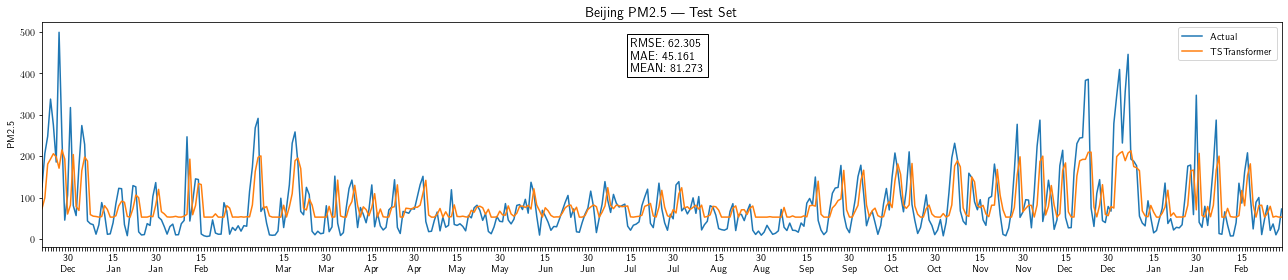

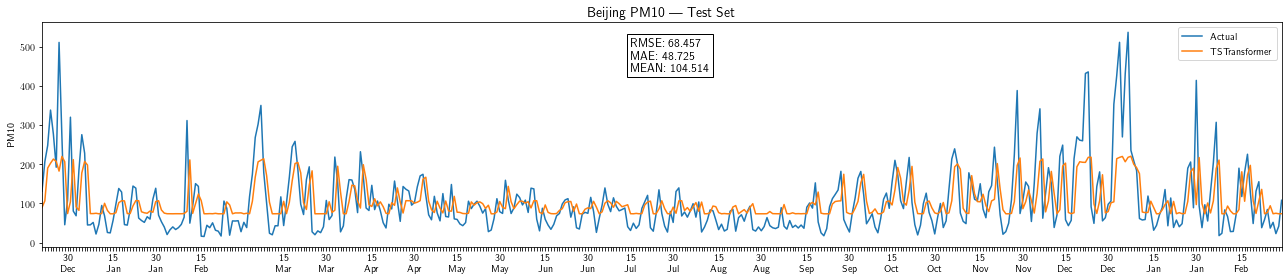

In [12]:
datasets = [("beijing_pm25", "PM2.5"),
            ("beijing_pm10", "PM10")]   
   
ax_list = list() 

for dataset_name, target_column in datasets:

    try:
        os.mkdir(MODEL_FOLDER + dataset_name)   
    except Exception as e:
        print(e)

    try:
        for name, model_fn in MODEL_LIST:
            os.mkdir(MODEL_FOLDER + f"{dataset_name}/{name}")
    except Exception as e:
        print(e)

    dataset = pickle.load(open(f"./Data/{dataset_name}_dataset.pkl", "rb"))
    perform_task(ax_list, dataset, dataset_name)